In [4]:
import xarray as xr
from mpl_toolkits.axes_grid1 import AxesGrid
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.geoaxes import GeoAxes
import matplotlib.pyplot as plt
import numpy as np
import xroms
import glob

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [5]:
y = 2010
paths = glob.glob('/d1/shared/TXLA_ROMS/output_20yr_obc/%i/ocean_his_00*.nc' % y)
# ds = xroms.open_roms_netcdf_dataset(path).sel(ocean_time='%i-08' %y)
# ds, grid = xroms.roms_dataset(ds, Vtransform=None)

ds = xroms.open_mfnetcdf(paths).sel(ocean_time='%i-08' %y)
# path = '/d1/shared/TXLA_ROMS/output_20yr_obc/%i/ocean_his_00*.nc' % y
# ds = xroms.open_roms_netcdf_dataset(path).sel(ocean_time='%i-08' %y)
dA_inv = ds.pn*ds.pm
budget = xr.open_dataset('files/budget.nc')

In [6]:
def background(ax, extent=[-95, -91, 27.99, 30], p=ccrs.PlateCarree(), res='10m', 
               mers=np.arange(-98, -86), pars=[28, 29, 30],):
    ax.set_extent(extent)
    ax.coastlines(resolution=res)
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', name='land',
                                                scale=res, facecolor='slategrey'))
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines',
                                                scale=res, edgecolor='blue', facecolor='none'))
    if ('PlateCarree' or 'Mercator') in str(p):
        lab = True
    else:
        lab = False
    gl = ax.gridlines(xlocs=mers, ylocs=pars, draw_labels=lab,
                      linewidth=0.5, color='k', linestyle=':')
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'rotation':'90'}
    return gl

In [7]:
calc = budget.sel(ocean_time='2010-08')
rate_av = calc['rate'].mean(dim='ocean_time').load() * dA_inv
hadv_av = calc['hadv'].mean(dim='ocean_time').load() * dA_inv
vadv_av = calc['vadv'].mean(dim='ocean_time').load() * dA_inv
vdiff_av = calc['vdiff'].mean(dim='ocean_time').load() * dA_inv
SOD_av = calc['SOD'].mean(dim='ocean_time')
res_av = -(hadv_av + vdiff_av - SOD_av - rate_av)

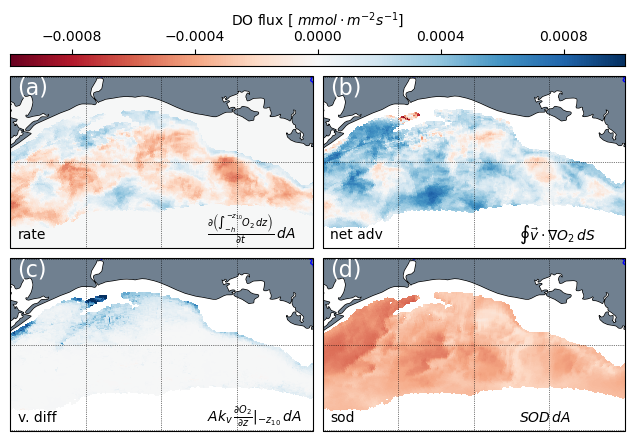

In [8]:
fig = plt.figure(figsize=(8.5,5), dpi=100)
axes_class = (GeoAxes, dict(map_projection=ccrs.PlateCarree()))
av_vars = [rate_av, (hadv_av + res_av), vdiff_av, -SOD_av]
labels = [r'$\frac{\partial Ox}{\partial t}$', 
          r'$\vec{v}\cdot \nabla Ox$',
          r'$Ak_v \, \frac{\partial{Ox}}{\partial{z}}$', 'SOD']

labels = [r'$\frac{\partial\left(\int_{-h}^{-z_{10}} O_2\,dz \right)}{\partial t}\,dA $',
         r'$\oint \vec{v}\cdot \nabla O_2 \,dS$',
         r'$Ak_v \, \frac{\partial{O_2}}{\partial{z}}|_{-z_{10}}\,dA $',
         '$SOD\,dA$' ]

wlabels = ['rate', 'net adv',
           'v. diff', 'sod',]

axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(2, 2),
                axes_pad=0.1,
                cbar_location='top',
                cbar_mode='single',
                cbar_pad=0.1,
                cbar_size='4%',
                label_mode='')

for ax, var, lb, lw, l in zip(axgr,av_vars, labels, wlabels, ['(a)', '(b)', '(c)', '(d)']):
    ax.set_aspect(1.13)
    gl = background(ax, extent=[-95, -91, 27.99, 30.01])
    if l !='C':
        gl.xlabels_bottom = gl.ylabels_left = False    
    mp = ax.pcolormesh(var.lon_rho, var.lat_rho, var, 
                         cmap='RdBu', vmin=-1e-3, vmax=1e-3)
    ax.text(-92.4, 28.1, lb)
    ax.text(-94.9, 28.1, lw)
    ax.text(-94.9, 29.8, l, color='w', fontsize=16)
cb = axgr.cbar_axes[0].colorbar(mp)
cb.set_label_text('DO flux [ $mmol \cdot m^{-2}s^{-1}$]')
# for ax, l in zip(axgr, ['(a)', '(b)', '(c)', '(d)']):
#     ax.text(-91.5, 29.7, l, fontsize=13)

    
fig.savefig('figures/flux_map.png')